In [ ]:
import os
import json
import numpy as np
import torch
from torch import nn
import torchvision
import random
from tqdm import *
from PIL import Image
from io import StringIO, BytesIO
import lpips

import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader


from pro_gan_pytorch.networks import create_generator_from_saved_model, create_generator_from_saved_model_opt
from pro_gan_pytorch.utils import adjust_dynamic_range
from torch.nn.functional import interpolate
import torchvision.transforms.functional as fn
from train_log import MeanTracker

from torch.utils.tensorboard import SummaryWriter

import model_rs as recsys_models

In [ ]:
device = 1
seed = 0

data_train = 'amazon'
out_dir = 'dummy_rec/'
latent_dim = 512
learning_rate = 0.00002
training_epoch = 1000
batch_size = 1
numofworkers= 4
gan_weights= '../PROGAN_AM_Fashion/Model_log_base/models/depth_7_epoch_50.bin' 

torch.cuda.set_device(device)
print('Cuda is Available: ', torch.cuda.is_available())
random.seed(seed)
torch.random.manual_seed(seed)

# print('Seed val fixed to: ', seed)

In [3]:
if data_train == 'amazon':

    dataset_name = 'AmazonFashion6ImgPartitioned.npy'
    dataset = np.load('../DVBPR/dataset/'+ dataset_name, encoding='bytes', allow_pickle=True)
    [user_train, _, _, Item, usernum, itemnum] = dataset

elif data_train == 'tradesy':

    dataset_name = 'TradesyImgPartitioned.npy'
    dataset = np.load('../DVBPR/data/' + dataset_name, encoding='bytes')
    [user_train, user_validation, user_test, Item, usernum, itemnum] = dataset
    cold_list = np.load('../data/tradesy_one_k_cold.npy')

In [4]:
def default_loader(path):
    img_pil =  Image.open(BytesIO(path)).convert('RGB')
    img_tensor = input_transform(img_pil)
    return img_tensor

# input_transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
#     # transforms.Normalize(mean=[0.485, 0.456, 0.406],
#     #                     std=[0.229, 0.224, 0.225])
#     # transforms.Normalize((0.6949, 0.6748, 0.6676), (0.3102, 0.3220, 0.3252))])
#     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
#     ])


input_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

class trainset(Dataset):
    def __init__(self, loader=default_loader):
        self.images_i = file_train_i
        self.images_j = file_train_j
        self.target = train_ls
        self.loader = loader

    def __getitem__(self, index):
        fn_i = self.images_i[index]
        img_i = self.loader(fn_i)
        fn_j = self.images_j[index]
        img_j = self.loader(fn_j)
        target = self.target[index]
        return img_i, img_j, target[0], target[1], target[2]

    def __len__(self):
        return len(self.images_i)



# helper scale function
def scale(x):
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    x = (x - x.min()) / (x.max() - x.min())
    return x

def scale_synth(x):
    # scale to feature_range and return scaled x
    x = adjust_dynamic_range(x,drange_in=(-1.0, 1.0), drange_out=(0.0, 1.0))
    return x

def scale_percept(x):
    # scale to feature_range and return scaled x
    x = adjust_dynamic_range(x,drange_in=(-1.0, 1.0), drange_out=(-1.0, 1.0))

    return x

def manual_normalize(x, mean, std):
    mean_ten = torch.Tensor(mean).unsqueeze(dim=0).unsqueeze(dim=2).unsqueeze(dim=3).cuda()
    std_ten = torch.Tensor(std).unsqueeze(dim=0).unsqueeze(dim=2).unsqueeze(dim=3).cuda()
    x = (x-mean_ten)/std_ten
    return x

def scale_rs(x):
    x = adjust_dynamic_range(x,drange_in=(-1.0, 1.0), drange_out=(0.0, 1.0))
    x = interpolate(x, size=(224, 224), mode='bilinear')
    x = manual_normalize(x, mean=[0.6949, 0.6748, 0.6676], std=[0.3102, 0.3220, 0.3252])
    return x


##### Initialize Dataset Object ######
def sample(user):
    u = random.randrange(usernum)
    numu = len(user[u])
    i = user[u][random.randrange(numu)][b'productid']
    M=set()
    for item in user[u]:
        M.add(item[b'productid'])
    while True:
        j=random.randrange(itemnum)
        if (not j in M): break
    return (u,i,j)

oneiteration = 0
for item in user_train: oneiteration+=len(user_train[item])

train_ls = [list(sample(user_train)) for _ in range(oneiteration)]

file_train_i = [Item[i][b'imgs'] for _,i,j in train_ls]
file_train_j = [Item[j][b'imgs'] for _,i,j in train_ls]

train_dataset  = trainset()


data_loader_train = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers = numofworkers, drop_last=True)
print("Total number of Train Samples: ",len(train_dataset))


Total number of Train Samples:  267635


In [5]:
class Progan_gen(nn.Module):
    def __init__(self, weights_root):
        super(Progan_gen, self).__init__()
        # self.G = create_generator_from_saved_model(weights_root)
        self.G = create_generator_from_saved_model_opt(weights_root)

        self.G_curr_depth = 7
        self.Actual_G_depth = 8

    def forward(self, z, delta):
        out = self.G(z, delta, self.G_curr_depth)
        return out

    # def gen_shifted(self, z, shift, delta):
    #     return self.forward(z + shift, [i+shift.unsqueeze(dim=1).unsqueeze(dim=2) for i in delta])

    def gen_shifted(self, z, shift, delta):
        return self.forward(z + shift, delta)


G = Progan_gen(gan_weights).cuda()
G = G.eval()


print('Generator Loaded!!')


criterion = nn.MSELoss()
percept = lpips.LPIPS(net='vgg').cuda()


Generator Loaded!!
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/skumar40/anaconda3/envs/Rs_attack/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/skumar40/anaconda3/envs/Rs_attack/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/skumar40/anaconda3/envs/Rs_attack/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


In [55]:
#### Defining models for GAN disentaglement
from constants import DEFORMATOR_TYPE_DICT
from latent_deformator import LatentDeformator, DeformatorType
from latent_shift_predictor import LatentShiftPredictorV3
from latent_shift_predictor import LatentReconstructor


## Define Static Variable
CE_loss = nn.CrossEntropyLoss()
# deformator_type = 'my_case'
deformator_type = 'my_case'

deformator_random_init = True
shift_predictor_size = None
shift_predictor_type = 'ResNet'
shift_distribution_key = 0 ## 0 for normal || 1 for uniform
seed = 2
device = 1
multi_gpu = False


shift_scale = 6.0
min_shift = 0.5
shift_distribution_type = shift_distribution_key

deformator_lr = 0.01
shift_predictor_lr = 0.01
n_steps = int(1000)
batch_size = 8

directions_count = batch_size
max_latent_dim = 512

label_weight = 1.0
shift_weight = 0.25
print_Every = 100


In [58]:
## takes in a list of [direction_count]

# for all those batches fetch the direction_count index
# generate a shift vector denotes how much you want to shift those directions corresponding target_indices
# manually normalize every shift magnitude above minimum shift
# for each of those batch size images (create a vector that basically tells for which images you will
# continued: modify which target indice and by how much)

def make_shifts(latent_dim):
    target_indices = torch.randperm(
        directions_count)[:batch_size].cuda()
    if shift_distribution_type == 0:
        shifts = torch.randn(target_indices.shape, device='cuda')
    elif shift_distribution_type == 1:
        shifts = 2.0 * torch.rand(target_indices.shape, device='cuda') - 1.0

    shifts = shift_scale * shifts
    shifts[(shifts < min_shift) & (shifts > 0)] = min_shift
    shifts[(shifts > -min_shift) & (shifts < 0)] = -min_shift

    try:
        latent_dim[0]
        latent_dim = list(latent_dim)
    except Exception:
        latent_dim = [latent_dim]

    z_shift = torch.zeros([batch_size] + latent_dim, device='cuda')
    for i, (index, val) in enumerate(zip(target_indices, shifts)):
        z_shift[i][index] += val

    return target_indices, shifts, z_shift



def make_shifts_1(shifts, z):
    """
    shifts shape should be (batch_size, 1)
    z shape should be (batch_size, 512) ProGAN
    """
    target_indices = torch.randperm(
        batch_size)[:batch_size].cuda()

    # shifts = shifts[target_indices]
    shifts = shift_scale * shifts
    shifts[(shifts < min_shift) & (shifts > 0)] = min_shift
    shifts[(shifts > -min_shift) & (shifts < 0)] = -min_shift

    return shifts


def calculate_percept_loss(img_shifted):
    k = img_shifted

    total_loss = 0

    for i in range(len(img_shifted)):
        fix_image = img_shifted[i].unsqueeze(dim=0).repeat(batch_size-1,1,1,1)
        rest_images = torch.cat([img_shifted[0:i], img_shifted[i+1:]], dim=0)
        perceptual_loss = percept(fix_image,rest_images).mean()
        total_loss += perceptual_loss

    return total_loss/len(img_shifted)

In [59]:
def log_train(step, should_print=True, stats=()):
    if should_print:
        out_text = '{}% [step {}]'.format(int(100 * step / n_steps), step)
        for named_value in stats:
            out_text += (' | {}: {:.2f}'.format(*named_value))
        print(out_text)

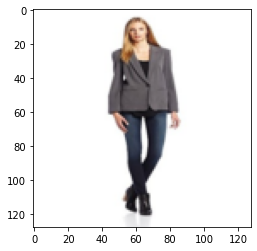

In [165]:
batch_image1, real_i, u, _, _ = next(iter(data_loader_train))

import matplotlib.pyplot as plt
plt.imshow(scale_synth(real_i)[0].permute(1,2,0))

In [166]:
# # deformator takes in the shape (2,200,1,1)
# deformator = LatentDeformator(shift_dim=[max_latent_dim],
#                                 input_dim=directions_count,
#                                 out_dim=max_latent_dim,
#                                 type=DEFORMATOR_TYPE_DICT[deformator_type],
#                                 random_init=deformator_random_init).cuda()

## shift predictor takes in a two set of images (real and shifted)
## output is (logits value, magnitude of shift[which image in batch was shifted by how much])
if shift_predictor_type == 'ResNet':
    # shift_predictor = LatentShiftPredictorv2(
    #     batch_size, shift_predictor_size).cuda()
    shift_predictor = LatentShiftPredictorV3(
        batch_size, shift_predictor_size).cuda()    
elif shift_predictor_type == 'LeNet':
    shift_predictor = LeNetShiftPredictor(
        batch_size, 1 if gan_type == 'SN_MNIST' else 3).cuda()

latent_recon = LatentReconstructor(batch_size).cuda()
print('Shift-predictor Loaded!')



print('Working on Recommender Models!!')

latent_rs_model = 100

def init_weights_rs(m):
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

rs_model = nn.DataParallel(recsys_models.pthDVBPR(latent_rs_model),device_ids=[device])
rs_model.apply(init_weights_rs)

print('Loading Rs Model Weights!!!!')
rs_path = '../AIP/models/ckpt/Newamazon_K100_19.tar'
rs_Weights = torch.load(rs_path)

rs_model.load_state_dict(rs_Weights['model_state_dict'])
rs_model.eval()

thetau = torch.from_numpy(rs_Weights['U']).cuda()

Shift-predictor Loaded!
Working on Recommender Models!!
Loading Rs Model Weights!!!!


In [98]:
G.cuda().eval()
real_img = real_i.cuda()

dlatent=torch.randn((1,512),requires_grad=True,device=device)

deformator_opt=torch.optim.Adam([dlatent],lr=0.01,betas=(0.9,0.999),eps=1e-8)
schedule_lr = torch.optim.lr_scheduler.StepLR(deformator_opt, step_size=200, gamma=0.5)

recovered_step = 0
for step in range(recovered_step, 1000, 1):
    G.zero_grad()
    ###### Optimizing Dlatent #######
    deformator_opt.zero_grad()

    # dlatent_mean, dlatent_std = dlatent.mean(), dlatent.std()
    # dlatent.data = (dlatent.data-dlatent_mean)/dlatent_std

    dlatent_img = scale_percept(G(dlatent, [0,0]))
    perceptual_loss = percept(dlatent_img,real_img).mean()
    mse_loss = criterion(dlatent_img, real_img)
    dlatent_loss = mse_loss + perceptual_loss

    dlatent_loss.backward()
    deformator_opt.step()

    if step%100==0:
        print("iter{}: loss -- {},  mse_loss --{},  percep_loss --{}".format(step,dlatent_loss.item(),mse_loss.item(),perceptual_loss.item()))

iter0: loss -- 1.2935445308685303,  mse_loss --0.7466624975204468,  percep_loss --0.5468820929527283
iter100: loss -- 0.7557321786880493,  mse_loss --0.2762877345085144,  percep_loss --0.4794444739818573
iter200: loss -- 0.6729457974433899,  mse_loss --0.2345775067806244,  percep_loss --0.4383682906627655
iter300: loss -- 0.6435534358024597,  mse_loss --0.2227693796157837,  percep_loss --0.420784056186676
iter400: loss -- 0.6300150752067566,  mse_loss --0.21730153262615204,  percep_loss --0.41271352767944336
iter500: loss -- 0.6225254535675049,  mse_loss --0.21389934420585632,  percep_loss --0.40862607955932617
iter600: loss -- 0.6144208312034607,  mse_loss --0.2102147340774536,  percep_loss --0.4042060971260071
iter700: loss -- 0.6055546998977661,  mse_loss --0.20802998542785645,  percep_loss --0.39752474427223206
iter800: loss -- 0.599713921546936,  mse_loss --0.20558610558509827,  percep_loss --0.3941277861595154
iter900: loss -- 0.5934344530105591,  mse_loss --0.20223760604858398, 

In [167]:
G.cuda().eval()
real_img = real_i.cuda()
user_nu = u[0]

dlatent=torch.randn((1,512),requires_grad=True,device=device)

deformator_opt=torch.optim.Adam([dlatent],lr=0.01,betas=(0.9,0.999),eps=1e-8)
schedule_lr = torch.optim.lr_scheduler.StepLR(deformator_opt, step_size=200, gamma=0.5)

recovered_step = 0
for step in range(recovered_step, 1000, 1):
    G.zero_grad()
    ###### Optimizing Dlatent #######
    deformator_opt.zero_grad()

    dlatent_mean, dlatent_std = dlatent.mean(), dlatent.std()
    dlatent.data = (dlatent.data-dlatent_mean)/dlatent_std

    dlatent_img = scale_percept(G(dlatent, [0,0]))
    perceptual_loss = percept(dlatent_img,real_img).mean()
    mse_loss = criterion(dlatent_img, real_img)
    dlatent_loss = mse_loss + perceptual_loss

    dlatent_loss.backward()
    deformator_opt.step()
    # schedule_lr.step()
    if step%100==0:
        print("iter{}: dl_loss: {:.2f}| mse_loss: {:.2f}| Percept: {:.2f}".format(step,dlatent_loss.item(),mse_loss.item(),perceptual_loss.item()))

print()
print()
dlatent_shift=torch.randn((batch_size,512),requires_grad=True,device=device)
shift_opt = torch.optim.Adam([dlatent_shift], lr=deformator_lr)
shift_predictor.cuda().train()
shift_predictor_opt = torch.optim.Adam(
    shift_predictor.parameters(), lr=shift_predictor_lr)

dlatent = dlatent.detach()
n_steps = 1000
for step in range(recovered_step, n_steps, 1): 
    G.zero_grad()
    ##### Optimizing dlatent shift #####
    shift_opt.zero_grad()
    shift_predictor_opt.zero_grad()

    target_indices = torch.randperm(batch_size)[:batch_size].cuda()
    max_shift = 0.4
    shifts = max_shift * dlatent_shift[target_indices]
    shifts = torch.clamp(shifts, min=-max_shift, max=max_shift)
    z_shift = dlatent.detach() + shifts


    z_shift_mean, z_shift_std = z_shift.mean(), z_shift.std()
    z_shift = (z_shift-z_shift_mean)/z_shift_std

    # Deformation
    imgs = scale_percept(G(z_shift,[0,0]))
    logits, predicted_shifts = shift_predictor(imgs)
    logit_loss = label_weight * CE_loss(logits, target_indices)
    shift_loss = torch.mean(torch.abs(predicted_shifts - shifts))

    ### User Preference
    rs_in = imgs
    rs_feat = rs_model(rs_in)
    # Preference_score = torch.log(torch.sigmoid(torch.mul(thetau[user_nu],rs_feat).sum(1))).mean()
    Preference_score = torch.mul(thetau[user_nu],rs_feat).sum(1).mean()

    # total loss
    loss = 0.1*logit_loss + shift_loss + 0.3*(-1*Preference_score)
    # loss = -1*Preference_score
    loss.backward()

    shift_opt.step()

    shift_predictor_opt.step()
    # update statistics trackers
    if step%100==0:
        print("iter{}: loss: {:.2f}| logit_loss: {:.2f}| shift_loss: {:.2f}| Preference_score: {:.2f}".format(step,loss.item(),logit_loss.item(),shift_loss.item(),Preference_score.item()))


iter0: dl_loss: 0.81| mse_loss: 0.43| Percept: 0.38
iter100: dl_loss: 0.54| mse_loss: 0.21| Percept: 0.33
iter200: dl_loss: 0.51| mse_loss: 0.19| Percept: 0.32
iter300: dl_loss: 0.50| mse_loss: 0.19| Percept: 0.31
iter400: dl_loss: 0.48| mse_loss: 0.18| Percept: 0.31
iter500: dl_loss: 0.45| mse_loss: 0.15| Percept: 0.30
iter600: dl_loss: 0.38| mse_loss: 0.11| Percept: 0.27
iter700: dl_loss: 0.11| mse_loss: 0.04| Percept: 0.08
iter800: dl_loss: 0.10| mse_loss: 0.03| Percept: 0.07
iter900: dl_loss: 0.10| mse_loss: 0.03| Percept: 0.07


iter0: loss: -0.39| logit_loss: 2.23| shift_loss: 0.44| Preference_score: 3.48
iter100: loss: -2.07| logit_loss: 0.04| shift_loss: 0.04| Preference_score: 7.06
iter200: loss: -2.23| logit_loss: 0.02| shift_loss: 0.02| Preference_score: 7.52
iter300: loss: -2.39| logit_loss: 0.01| shift_loss: 0.01| Preference_score: 8.02
iter400: loss: -2.51| logit_loss: 0.02| shift_loss: 0.02| Preference_score: 8.43
iter500: loss: -2.37| logit_loss: 0.01| shift_loss: 0.01|

In [30]:
rs_feat = rs_model(dlatent_img)
k1 = torch.mul(thetau[user_nu],rs_feat).sum(1)

In [31]:
rs_feat = rs_model(rs_in)
k2 = torch.mul(thetau[user_nu],rs_feat).sum(1)

In [32]:
k2-k1

tensor([4.2893, 6.5083, 7.2215, 5.4220, 6.0755, 6.4609, 7.5487, 6.6154, 7.2443,
        6.8101, 8.2616, 6.8871, 5.6493, 4.3941, 6.8382, 7.3344],
       device='cuda:1', grad_fn=<SubBackward0>)

In [168]:
img_shift, img_base=imgs.cpu().detach(), dlatent_img.cpu().detach()

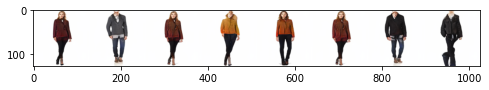

In [169]:
import matplotlib.pyplot as plt
Fake_images_grid = torchvision.utils.make_grid(scale_synth(img_shift).cpu().detach(), nrow=8, padding=0)
plt.figure(figsize=[8, 8])
plt.imshow(Fake_images_grid.permute(1,2,0))

In [170]:
i = 5
torchvision.utils.save_image(scale_synth(real_i)[0], 'raw_data_exp/our_image_real_{}.png'.format(i))
torchvision.utils.save_image(scale_synth(img_base)[0], 'raw_data_exp/our_image_base_{}.png'.format(i))
torchvision.utils.save_image(Fake_images_grid, 'raw_data_exp/our_image_final_{}.png'.format(i))


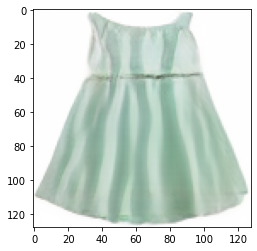

In [158]:
plt.imshow(scale_synth(img_base)[0].permute(1,2,0))

In [ ]:
plt.imshow(scale_synth(real_i)[0].permute(1,2,0))